In [1]:
import subprocess
import shlex

import graph_tool.all as gt
import numpy as np
import pandas as pd
from utils.WeightedCheckUtil import *
from utils.HubConnectivityScore import calculate_hcs_pair
from utils.SmallWorld import *

import csv

import glob
import os
import json

from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
analysis_folder = "./analysis_data/"

In [3]:
def runAlgorithm(**kwargs):
    
    # Default arguments of the method:
    default_args = {'type': 'gen', 'graph': "flower 1000 1 2", 'method': 'sketch', 'alpha': '1', 'least_coverage': '1',
           'sketch_k': '128', 'multipass': '10000', 'rad_min': '1', 'rad_max': '30', 'random_seed': '114514'}
    
    options = ""
    
    for key in kwargs:
        default_args[key] = kwargs[key]
        
    if default_args['type'] == 'gen':
        a = default_args['graph']
        default_args['graph'] = f'"{a}"'
            
    for key in default_args:
        options += f" -{key}={default_args[key]}"
        
    subprocess.run(shlex.split(f"./bin/box_cover {options}"), cwd='./graph_sketch_fractality')

In [4]:
def saveTSV(filePath, graph):
    with open(filePath, "w", newline="") as tsvfile:
        writer = csv.writer(tsvfile, delimiter="\t")

        for e in graph.edges():
            source = e.source()
            target = e.target()
            writer.writerow([source, target])

In [5]:
def get_latest_output_json():
    list_of_files = glob.glob('./graph_sketch_fractality/jlog/*')
    latest_file = max(list_of_files, key=os.path.getctime)

    f = open(latest_file, "r").read()
    json_file = json.loads(f)

    return json_file

In [6]:
def prepare_folder(graph_name):
    safe_graph_name = graph_name.replace('/', '__')
    path = f"{analysis_folder}{safe_graph_name}"
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [7]:
def save_json(path, json_file):
    with open(path, "w") as outfile:
        json.dump(json_file, outfile)

In [8]:
def set_plotting_style():
    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markeredgewidth'] = 2
    plt.rcParams['lines.markersize'] = 10
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['font.size'] = 20
    plt.rcParams['legend.fontsize'] = 20 * 0.6
    plt.rcParams['figure.subplot.left'] = 0.25
    plt.rcParams['figure.subplot.right'] = 0.95
    plt.rcParams['figure.subplot.bottom'] = 0.2
    plt.rcParams['figure.subplot.top'] = 0.9
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.minor.size'] = 4
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['xtick.major.size'] = 8
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['ytick.left'] = True
    plt.rcParams['ytick.right'] = True
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.minor.size'] = 4
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 8
    plt.rcParams['ytick.major.width'] = 2

In [9]:
def get_mst(graph):
    if "weight" in graph.edge_properties:
        graph.ep.weight.a *= -1
    else:
        # TODO: add logic of throw error
        print("no weight")
        return False
    mst_tree = gt.min_spanning_tree(graph, graph.ep.weight)

    return gt.GraphView(graph, efilt=mst_tree)

In [10]:
def wmse(y_fit, x, y, w):
    return sum(w * (y_fit - y) ** 2) / sum(w) / len(y_fit)

In [41]:
def calculate_n_plot_power_law(radius, size, folder_path):
    box_sizes = [rb for rb in radius]

    x = np.array(box_sizes)
    y = np.array(size)
    x_log = np.log10(box_sizes)
    y_log = np.log10(size)

    fit_pl = linregress(x_log, y_log)
    fit_exp = linregress(x, y_log)

    y_log_pl = fit_pl.slope * x_log + fit_pl.intercept
    y_log_exp = fit_exp.slope * x + fit_exp.intercept

    x_plot = np.linspace(x.min(), x.max(), 100)
    x_log_plot = np.log10(x_plot)
    y_log_exp_plot = fit_exp.slope * x_plot + fit_exp.intercept

    set_plotting_style()

    fig = plt.figure(figsize=(6, 6))
    plt.scatter(x_log, y_log)
    plt.plot(x_log, y_log_pl,
             label='$N_\mathrm{B}\propto l_\mathrm{B}^{%.2f}$' % fit_pl.slope)
    plt.plot(x_log_plot, y_log_exp_plot,
             label='$N_\mathrm{B}\propto e^{%.2f l_\mathrm{B}}$' % fit_exp.slope)
    plt.xlabel('$\log(l_\mathrm{B})$')
    plt.ylabel('$\log(N_\mathrm{B})$')
    plt.legend()
    plt.savefig(f"{folder_path}/power_law_fit.svg")

    wmse_pl = wmse(y_fit=y_log_pl, x=x_log, y=y_log, w=size)

    wmse_exp = wmse(y_fit=y_log_exp, x=x_log, y=y_log, w=size)

    pl_ex_ratio = wmse_pl / wmse_exp

    return wmse_pl, wmse_exp, pl_ex_ratio

In [42]:
def run_box_covering(graph, folder_path):
    mst = get_mst(graph)
    if(not mst):
        return np.nan, np.nan, np.nan
    tsv_path = f"{folder_path}/mst.tsv"
    saveTSV(tsv_path, mst)

    runAlgorithm(type="tsv", graph=f".{tsv_path}")

    json = get_latest_output_json()
    save_json(f"{folder_path}/box_result.json", json)

    radius = json['radius']
    size = json['size']

    return calculate_n_plot_power_law(radius, size, folder_path)

In [12]:
def calculate_assortativity(graph, degree_property):
    assortativity_undirected, variance_undirected = gt.assortativity(graph, deg=degree_property)
    return assortativity_undirected, variance_undirected

In [16]:
def create_series(
        graph_name,
        modularity_score,
        small_world_coefficient,
        hcs_std,
        hcs_mean,
        assortativity_undirected,
        variance_undirected,
        wmse_pl,
        wmse_exp,
        pl_ex_ratio
):
    return pd.Series({
        'name': graph_name,
        'modularity': modularity_score,
        'small_world': small_world_coefficient,
        'hcs_std': hcs_std,
        'hcs_mean': hcs_mean,
        'assortativity': assortativity_undirected,
        'variance': variance_undirected,
        'wmse_pl': wmse_pl,
        'wmse_exp': wmse_exp,
        'pl_ex_ratio': pl_ex_ratio
    })

In [17]:
def run_analysis(graph_name):
    path = prepare_folder(graph_name)

    graph = gt.collection.ns[graph_name]

    wmse_pl, wmse_exp, pl_ex_ratio = run_box_covering(graph, path)
    if wmse_pl is np.nan:
        return create_series(graph_name, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    assortativity_undirected, variance_undirected = calculate_assortativity(
        graph, "total")

    hcs_std, hcs_mean = calculate_hcs_pair(graph)

    swr = SmallWorldResult.build(graph)

    graph_state = gt.minimize_blockmodel_dl(graph, state=gt.PPBlockState)

    modularity_score = gt.modularity(graph, graph_state.get_blocks())

    return create_series(
        graph_name,
        modularity_score,
        swr.small_world_coefficient,
        hcs_std,
        hcs_mean,
        assortativity_undirected,
        variance_undirected,
        wmse_pl,
        wmse_exp,
        pl_ex_ratio
    )

[0422 22:09:12] JLOG: box_cover.9f89a6ef4075.jlog.250422-220912.16461
[0422 22:09:12] run.program = box_cover
[0422 22:09:12] run.args = ./bin/box_cover
[0422 22:09:12] run.args = -type=tsv
[0422 22:09:12] run.args = -graph=../analysis_data/new_zealand_collab/mst.tsv
[0422 22:09:12] run.args = -method=sketch
[0422 22:09:12] run.args = -alpha=1
[0422 22:09:12] run.args = -least_coverage=1
[0422 22:09:12] run.args = -sketch_k=128
[0422 22:09:12] run.args = -multipass=10000
[0422 22:09:12] run.args = -rad_min=1
[0422 22:09:12] run.args = -rad_max=30
[0422 22:09:12] run.args = -random_seed=114514
[0422 22:09:12] run.machine = 9f89a6ef4075
[0422 22:09:12] run.date = 2025/04/22 22:09:12
[0422 22:09:12] run.user = =========
  Vertices: 1511
  Edges: 2974
  Type: agl::basic_graph<int>
----------
  0 -> 518
  1 -> 117
  2 -> 117
  3 -> 218
  4 -> 518
  ...
----------
  0 <- 518
  1 <- 117
  2 <- 117
  3 <- 218
  4 <- 518
  ...
  Vertices: 1463
  Edges: 2924
  Type: agl::basic_graph<int>
-------

Info: Found N_hub=24 hubs (degree > 52.94).
Info: Found E_hub=231 edges among hubs.
Info: Found N_hub=95 hubs (degree > 11.31).
Info: Found E_hub=1024 edges among hubs.


name             new_zealand_collab
modularity                 0.204891
small_world                0.000001
hcs_std                       9.625
hcs_mean         10.778947368421052
assortativity             -0.001474
variance                   0.002793
wmse_pl                    0.005019
wmse_exp                   0.000465
pl_ex_ratio               10.788555
dtype: object

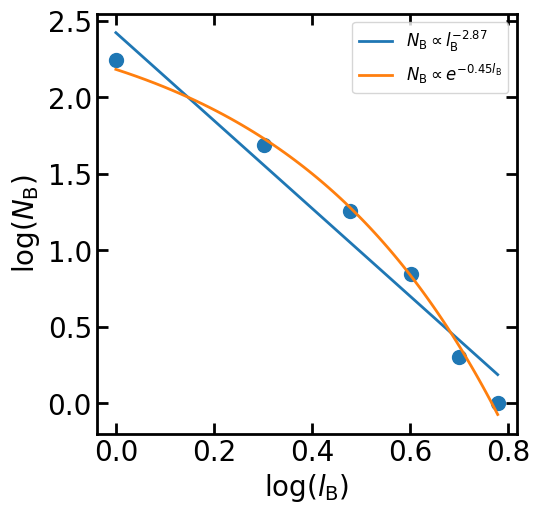

In [32]:
run_analysis('new_zealand_collab')

In [15]:
get_latest_output_json()

{'run': {'program': 'box_cover',
  'args': ['./bin/box_cover',
   '-type=tsv',
   '-graph=./analysis_data/new_zealand_collab/mst.tsv',
   '-method=sketch',
   '-alpha=1',
   '-least_coverage=1',
   '-sketch_k=128',
   '-multipass=10000',
   '-rad_min=1',
   '-rad_max=30',
   '-random_seed=114514'],
  'machine': '9f89a6ef4075',
  'date': '2025/04/22',
  'user': '',
  'pid': 16179,
  'time': 0.000231028,
  'memory': 2142208}}

In [ ]:
import dask
from dask import delayed
import time
import os


def start_pipe_parallel(data):
    results_delayed = [delayed(run_analysis)(i) for i in data]

    # Execute the graph in parallel (uses multiprocessing or threading backend by default)
    # Specify scheduler='processes' for CPU-bound work
    print("Computing results...")
    start_time = time.time()
    results = dask.compute(*results_delayed, scheduler='processes') # Use processes for CPU-bound
    end_time = time.time()

    print(f"\nResults: {results}")
    print(f"Dask computation finished in {end_time - start_time:.2f} seconds")

    return results

In [34]:
def start_pipe(data):
    results = []
    print("Computing results...")
    start_time = time.time()

    for graph_name in data:
        result = run_analysis(graph_name)
        results.append(result)

    end_time = time.time()

    print(f"Dask computation finished in {end_time - start_time:.2f} seconds")

    return results

Computing results...


[0423 07:27:43] JLOG: box_cover.9f89a6ef4075.jlog.250423-072743.17808
[0423 07:27:43] run.program = box_cover
[0423 07:27:43] run.args = ./bin/box_cover
[0423 07:27:43] run.args = -type=tsv
[0423 07:27:43] run.args = -graph=../analysis_data/london_transport/mst.tsv
[0423 07:27:43] run.args = -method=sketch
[0423 07:27:43] run.args = -alpha=1
[0423 07:27:43] run.args = -least_coverage=1
[0423 07:27:43] run.args = -sketch_k=128
[0423 07:27:43] run.args = -multipass=10000
[0423 07:27:43] run.args = -rad_min=1
[0423 07:27:43] run.args = -rad_max=30
[0423 07:27:43] run.args = -random_seed=114514
[0423 07:27:43] run.machine = 9f89a6ef4075
[0423 07:27:43] run.date = 2025/04/23 07:27:43
[0423 07:27:43] run.user = =========
  Vertices: 369
  Edges: 736
  Type: agl::basic_graph<int>
----------
  0 -> 1, 352
  1 -> 0, 321, 347
  2 -> 3, 216
  3 -> 2, 224, 258, 260, 338
  4 -> 6, 301
  ...
----------
  0 <- 1, 352
  1 <- 0, 321, 347
  2 <- 3, 216
  3 <- 2, 224, 258, 260, 338
  4 <- 6, 301
  ...
  

Info: Found N_hub=16 hubs (degree > 4.52).
Info: Found E_hub=7 edges among hubs.
Info: Found N_hub=16 hubs (degree > 4.78).
Info: Found E_hub=7 edges among hubs.


[0423 07:27:43] time = 0.00540209
[0423 07:27:43] size = 245
[0423 07:27:43] radius = 1
[0423 07:27:43] coverage = 1
[0423 07:27:43] 1 = 114
[0423 07:27:43] 1 = 214
[0423 07:27:43] 1 = 643
[0423 07:27:43] 1 = 506
[0423 07:27:43] 1 = 1318
[0423 07:27:43] 1 = 276
[0423 07:27:43] 1 = 1128
[0423 07:27:43] 1 = 1248
[0423 07:27:43] 1 = 343
[0423 07:27:43] 1 = 41
[0423 07:27:43] 1 = 1086
[0423 07:27:43] 1 = 716
[0423 07:27:43] 1 = 470
[0423 07:27:43] 1 = 47
[0423 07:27:43] 1 = 258
[0423 07:27:43] 1 = 889
[0423 07:27:43] 1 = 1238
[0423 07:27:43] 1 = 949
[0423 07:27:43] 1 = 433
[0423 07:27:43] 1 = 193
[0423 07:27:43] 1 = 288
[0423 07:27:43] 1 = 911
[0423 07:27:43] 1 = 430
[0423 07:27:43] 1 = 658
[0423 07:27:43] 1 = 469
[0423 07:27:43] 1 = 340
[0423 07:27:43] 1 = 249
[0423 07:27:43] 1 = 477
[0423 07:27:43] 1 = 971
[0423 07:27:43] 1 = 810
[0423 07:27:43] 1 = 1383
[0423 07:27:43] 1 = 1284
[0423 07:27:43] 1 = 892
[0423 07:27:43] 1 = 238
[0423 07:27:43] 1 = 979
[0423 07:27:43] 1 = 938
[0423 07:27:43

Info: Found N_hub=24 hubs (degree > 52.94).
Info: Found E_hub=231 edges among hubs.
Info: Found N_hub=95 hubs (degree > 11.31).
Info: Found E_hub=1024 edges among hubs.


[0423 07:27:45] JLOG: box_cover.9f89a6ef4075.jlog.250423-072745.17818
[0423 07:27:45] run.program = box_cover
[0423 07:27:45] run.args = ./bin/box_cover
[0423 07:27:45] run.args = -type=tsv
[0423 07:27:45] run.args = -graph=../analysis_data/bible_nouns/mst.tsv
[0423 07:27:45] run.args = -method=sketch
[0423 07:27:45] run.args = -alpha=1
[0423 07:27:45] run.args = -least_coverage=1
[0423 07:27:45] run.args = -sketch_k=128
[0423 07:27:45] run.args = -multipass=10000
[0423 07:27:45] run.args = -rad_min=1
[0423 07:27:45] run.args = -rad_max=30
[0423 07:27:45] run.args = -random_seed=114514
[0423 07:27:45] run.machine = 9f89a6ef4075
[0423 07:27:45] run.date = 2025/04/23 07:27:45
[0423 07:27:45] run.user = =========
  Vertices: 1773
  Edges: 3502
  Type: agl::basic_graph<int>
----------
  0 -> 51, 56, 59, 65, 71, 100, 134, 135, 145, 149, ...
  1 -> 109, 179, 206, 228, 236, 237, 253, 259, 267, 291, ...
  2 -> 4, 165, 632, 1432, 1469, 1471, 1555, 1576, 1619, 1622, ...
  3 -> 5, 6, 11, 26, 36, 

Info: Found N_hub=53 hubs (degree > 46.05).
Info: Found E_hub=489 edges among hubs.
Info: Found N_hub=202 hubs (degree > 20.60).
Info: Found E_hub=2213 edges among hubs.
Dask computation finished in 5.92 seconds


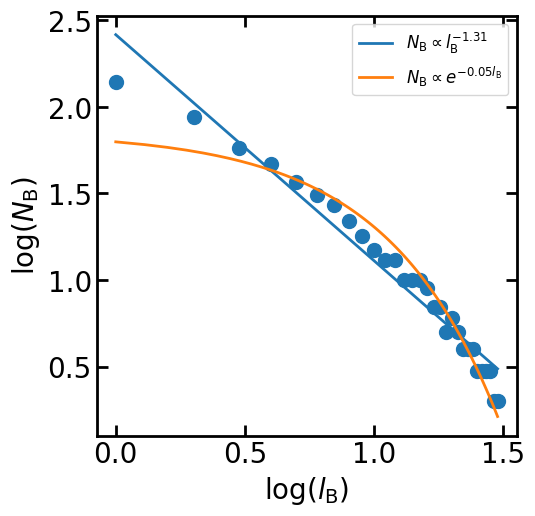

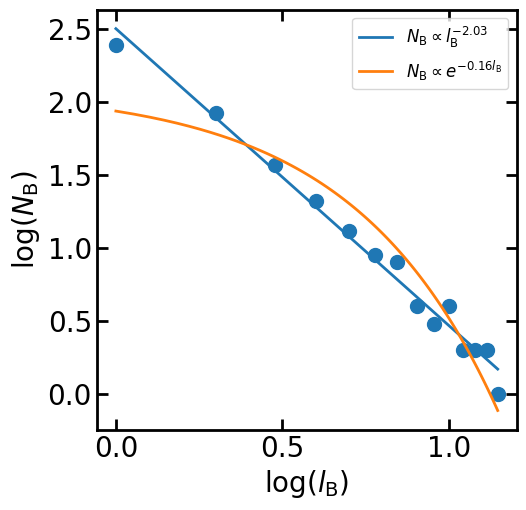

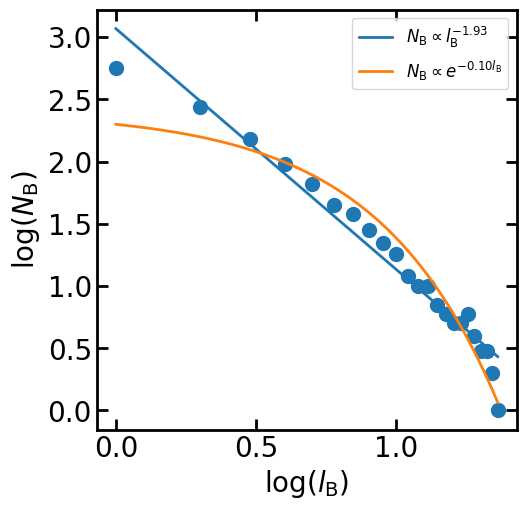

In [47]:
#results = start_pipe(["human_brains/BNU1_0025915_2_DTI_DS16784", "physics_collab/arXiv"])
results = start_pipe(["london_transport", "new_zealand_collab", "bible_nouns"])

In [37]:
json_test = json.loads(open(f"{analysis_folder}human_brains__BNU1_0025915_2_DTI_DS16784/box_result.json", "r").read())

(0.0008285993482828621, 0.004942150702519501, 0.167659668463862)

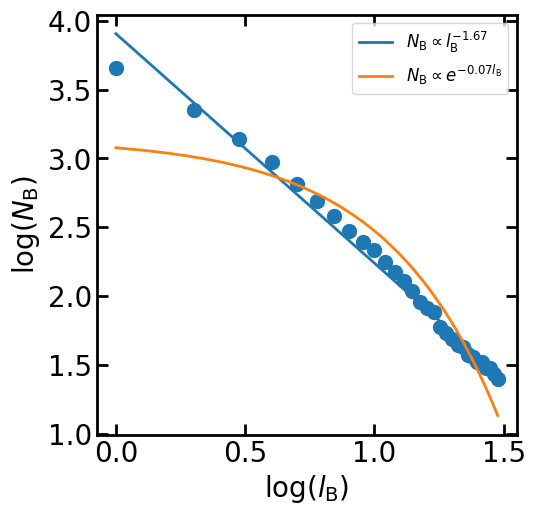

In [43]:
calculate_n_plot_power_law(json_test['radius'], json_test['size'], f"{analysis_folder}human_brains__BNU1_0025915_2_DTI_DS16784")

In [45]:
#physics_collab__arXiv
json_test = json.loads(open(f"{analysis_folder}physics_collab__arXiv/box_result.json", "r").read())

(0.0022249400104552134, 0.006334903307116411, 0.3512192534897562)

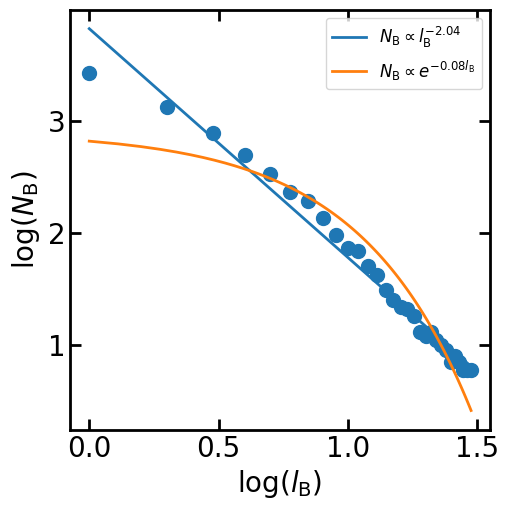

In [46]:
calculate_n_plot_power_law(json_test['radius'], json_test['size'], f"{analysis_folder}physics_collab__arXiv")